# Introduction
Data of 4803 movies from [The Movie Database API](https://www.themoviedb.org/) with 21 different fields.
Answer 3 questions:
<ol>
<li>What areas have the most influence on revenue?</li>
<li>How is a movie’s revenue and average score affected by its genre?</li>
<li>What influence does release date have on revenue?</li>
</ol>

# Data description

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

import os
import pickle
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import sklearn

In [2]:
# read the data
tmdb_5000_movies=pd.read_csv("./input/tmdb_5000_movies.csv",index_col="id")
tmdb_5000_credits=pd.read_csv("./input/tmdb_5000_credits.csv",index_col="movie_id")
tmdb_5000=pd.merge(tmdb_5000_movies,tmdb_5000_credits)

In [3]:
tmdb_5000.shape

(4809, 21)

Total rows: 4809<br>
Total data fields: 21

Example of the first row

In [4]:
tmdb_5000.head(1)

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# Visualizations
## Top 30 movies with highest budget

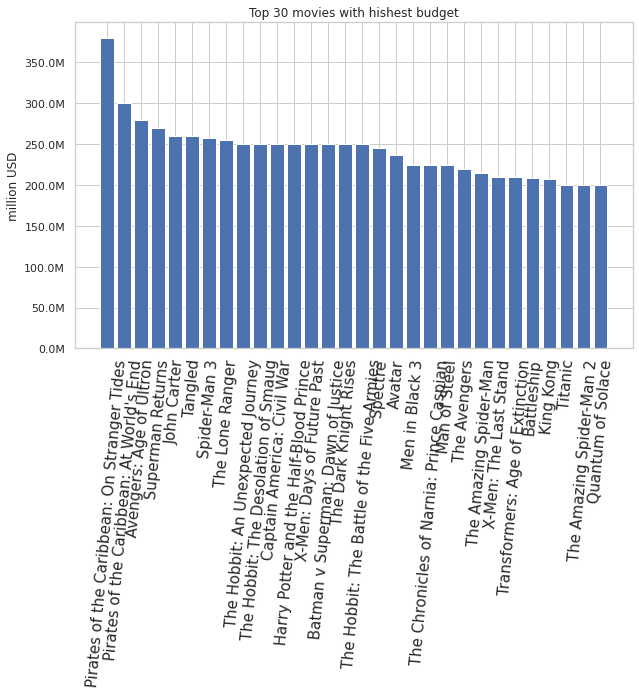

In [5]:
# print top 30 movies with highest budget
data_1 = tmdb_5000.loc[:,['budget','original_title']].sort_values(by=['budget'], ascending=False).head(30)

# format million USD for y axis
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

# draw plot
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15) # rotate the x-axis's label
plt.title('Top 30 movies with hishest budget')
ax.set_ylabel('million USD', fontsize='medium') # edit the y-axis label
ax.yaxis.set_major_formatter(formatter) # change the y-axis's label
ax.bar(data_1.loc[:, 'original_title'].values, data_1.loc[:, 'budget'].values, align="center")
plt.show()

## Number of movies by genres

In [6]:
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def multi_bar(series):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
    plt.show()
    
def multi_pie(series):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.pie(count.values(),labels=count.keys())
    plt.show()

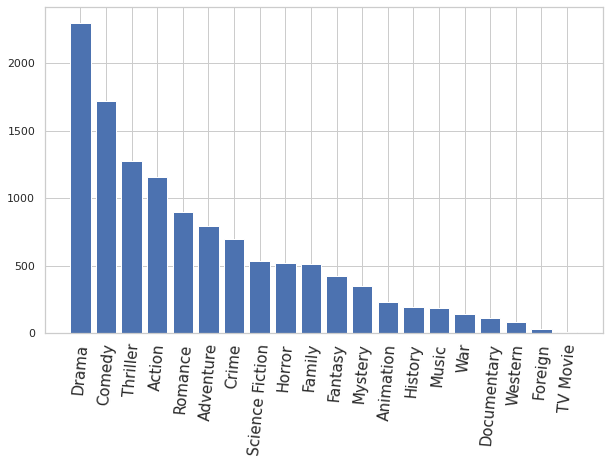

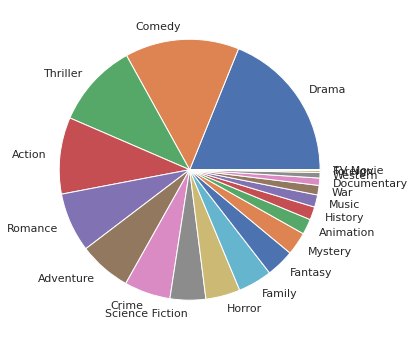

In [7]:
multi_bar(tmdb_5000.genres)
multi_pie(tmdb_5000.genres)

## Number of movies by keywords

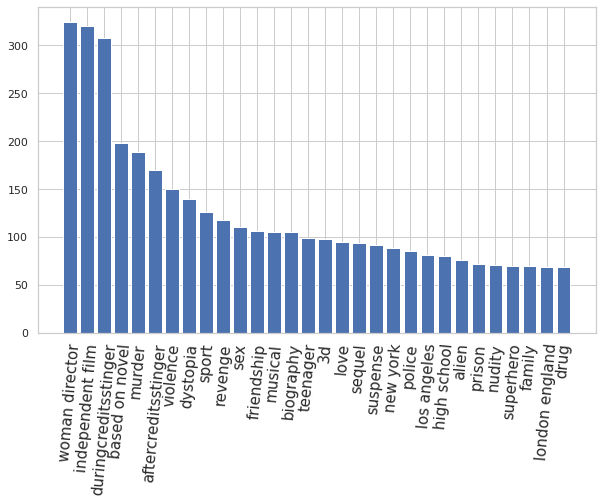

In [8]:
multi_bar(tmdb_5000.keywords)

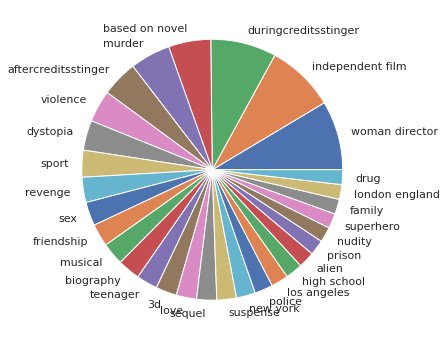

In [9]:
multi_pie(tmdb_5000.keywords)

## Movies's revenue and popularity by genres

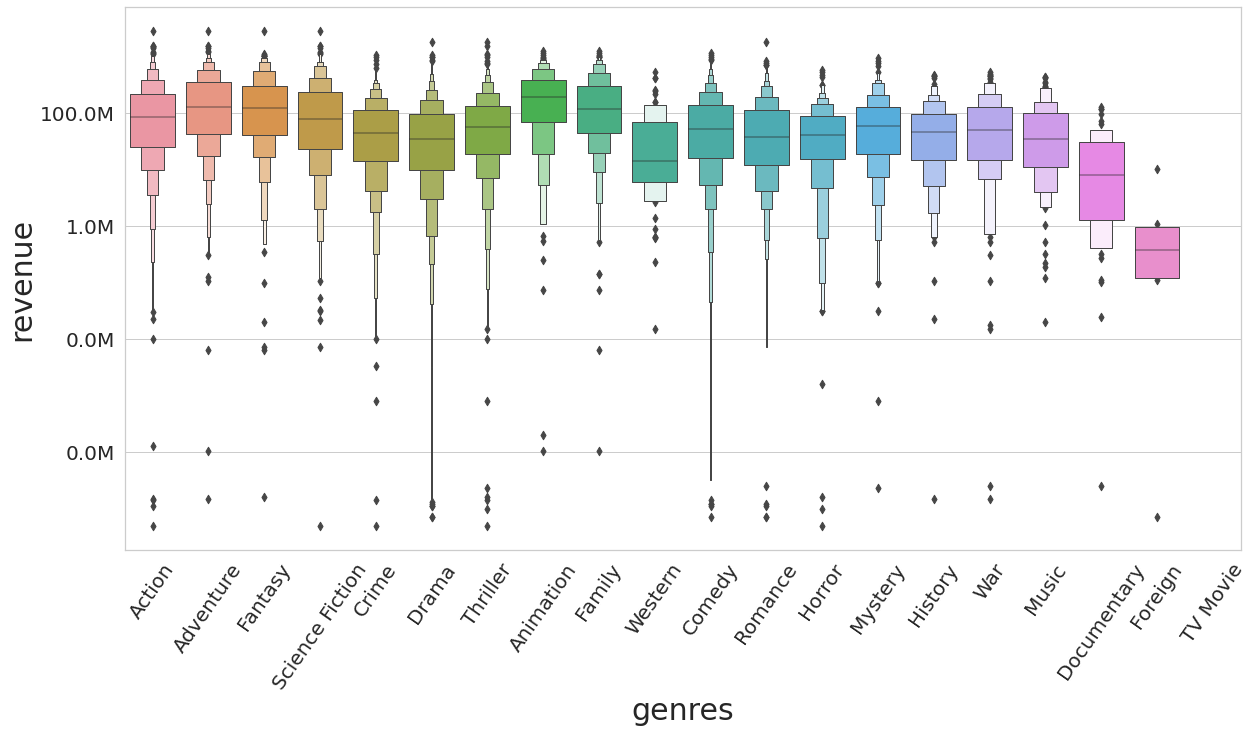

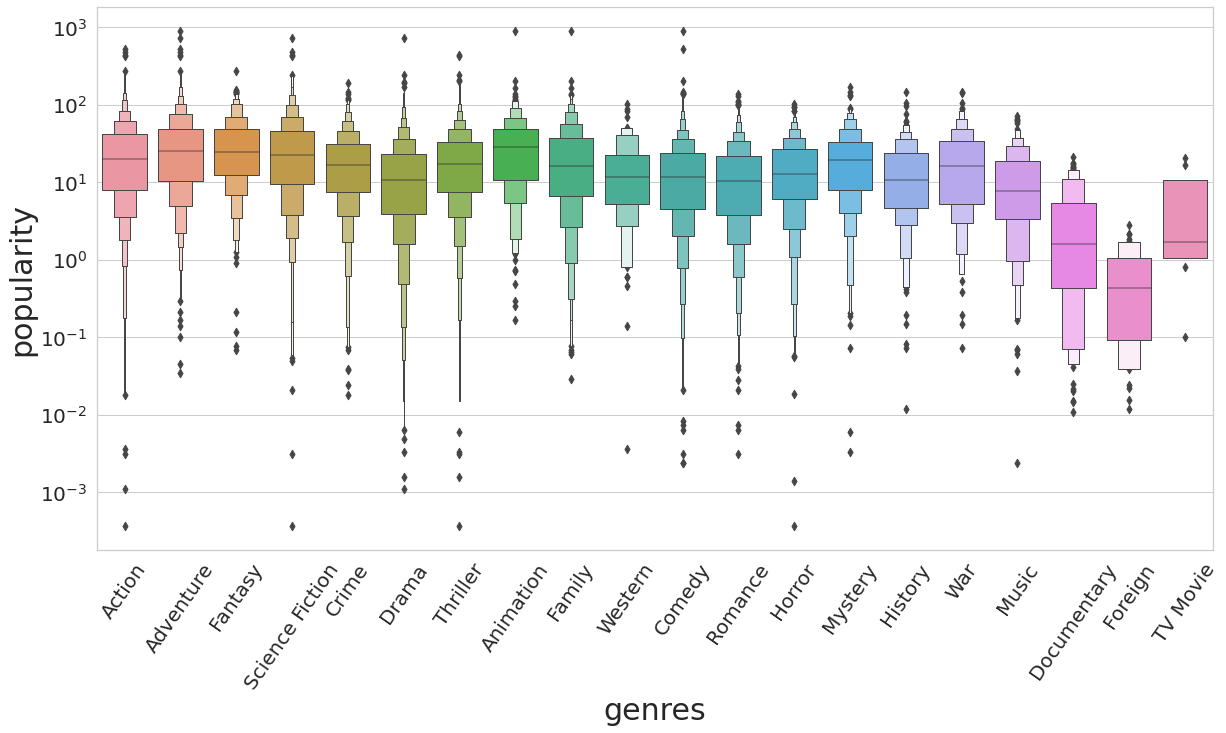

In [10]:
def group_indices(series,index='id'):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def expand_multi_feature(df,column,index='id'):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def plotby_box(df,x,y,yscale="linear", yformat = False):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.boxenplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if yformat:ax.yaxis.set_major_formatter(formatter)
    plt.show()

plotby_box(tmdb_5000, 'genres', 'revenue', yscale='log', yformat = True)
plotby_box(tmdb_5000, 'genres', 'popularity', yscale='log')


## Movies' runtime by genres

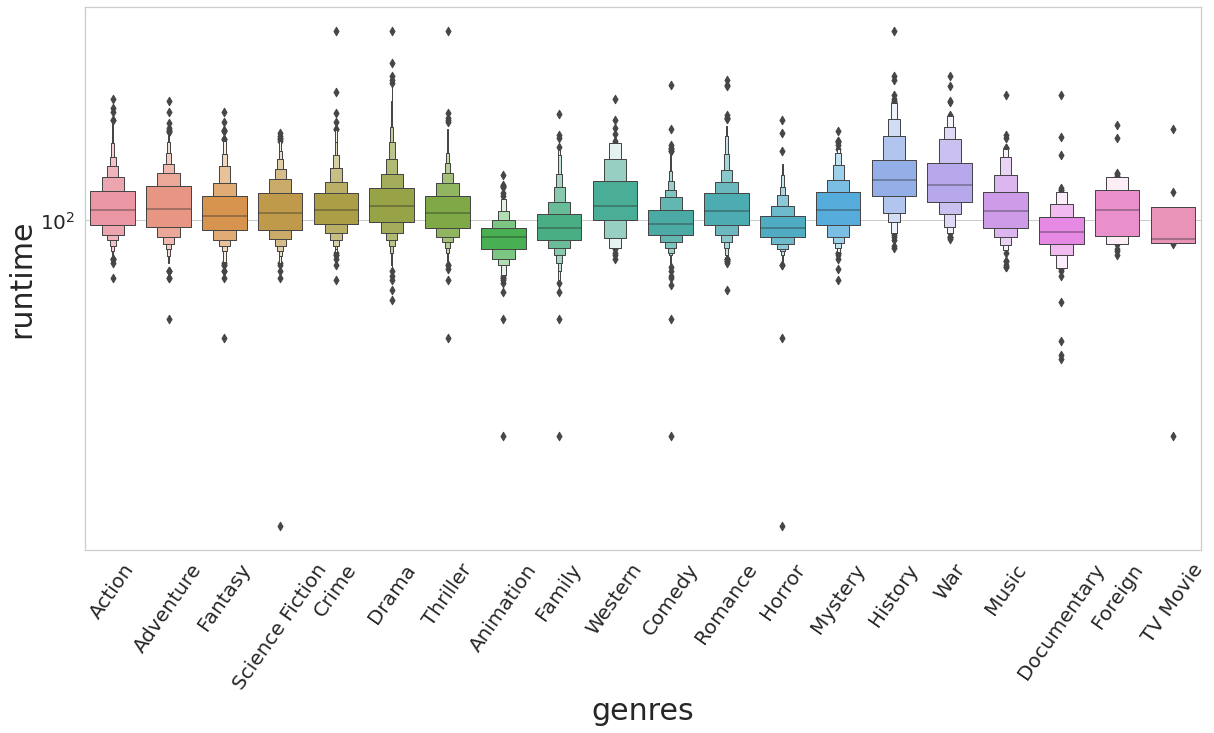

In [11]:
plotby_box(tmdb_5000, 'genres', 'runtime', yscale='log')

## Movies' average vote and vote count by genres

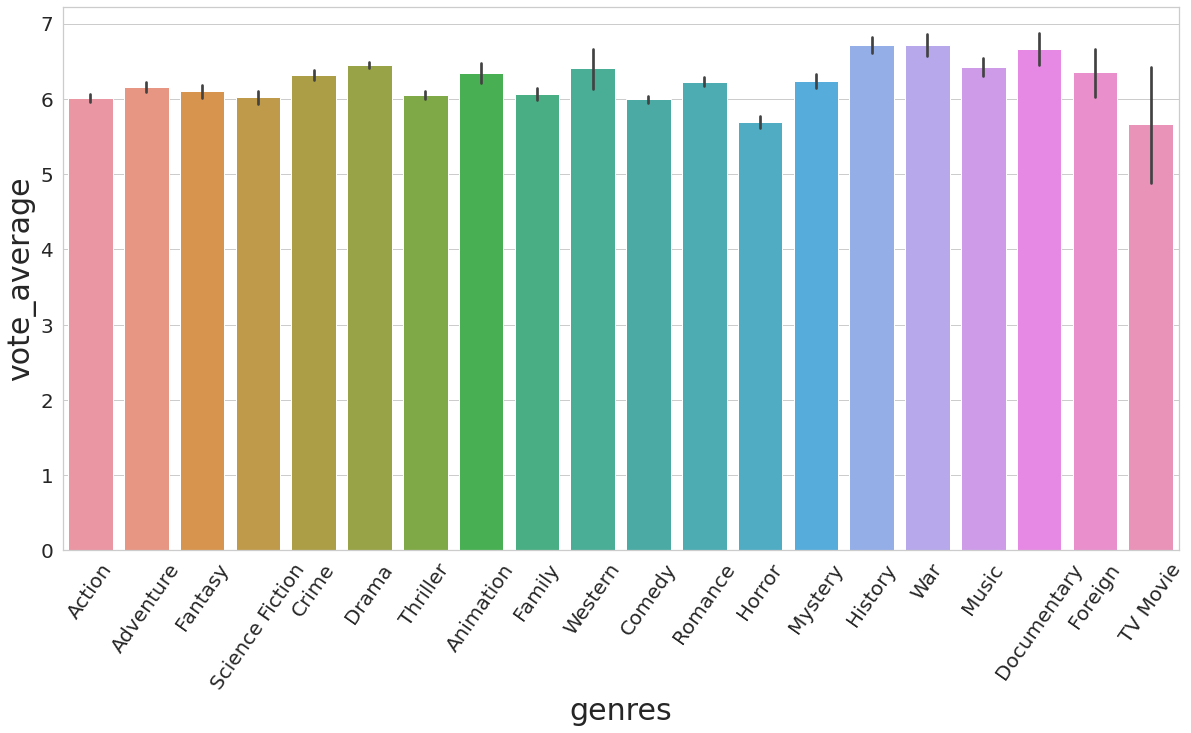

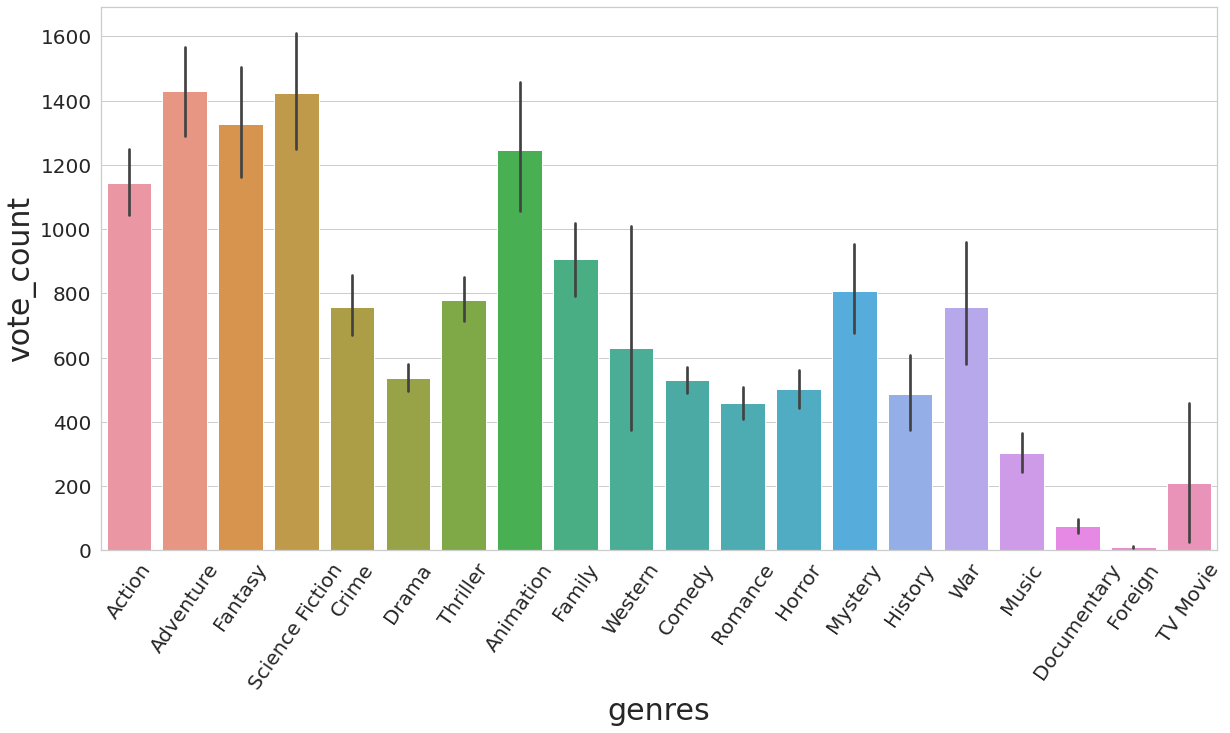

In [12]:
def plotby_bar(df,x,y):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.barplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    plt.show()

plotby_bar(tmdb_5000,"genres","vote_average")
plotby_bar(tmdb_5000,"genres","vote_count")
    

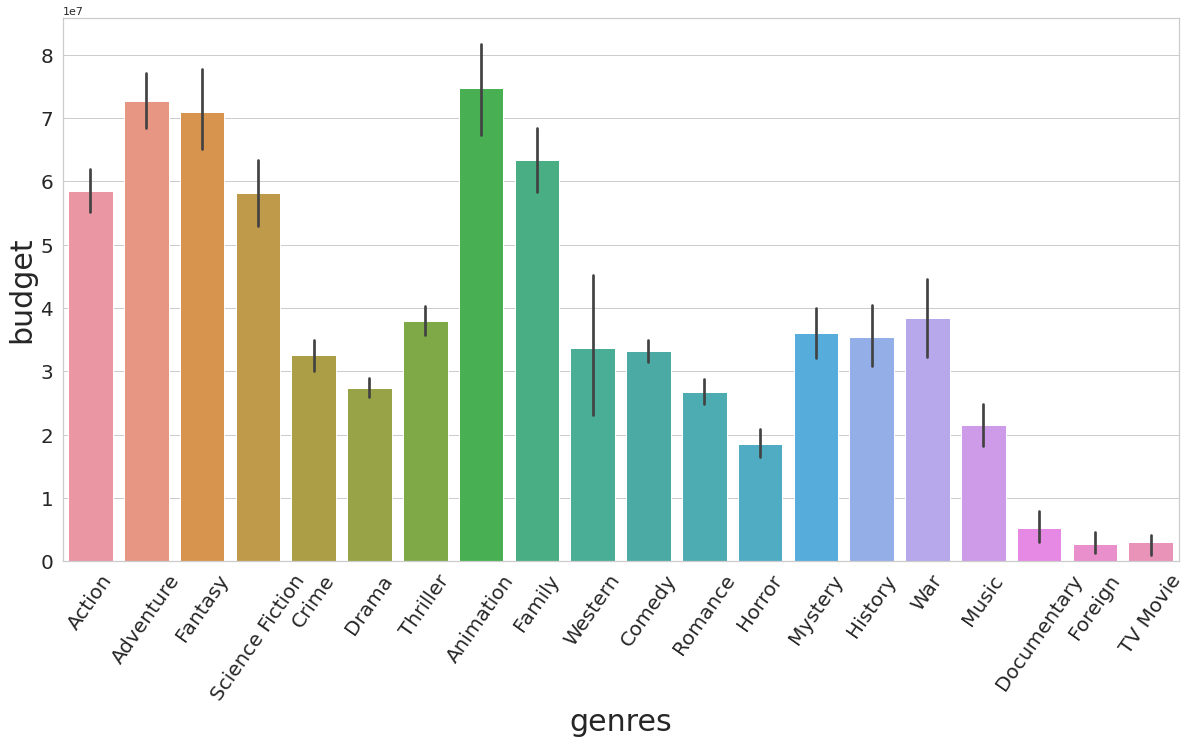

In [13]:
plotby_bar(tmdb_5000,"genres","budget")

## Relationship of revenue and budget by genres

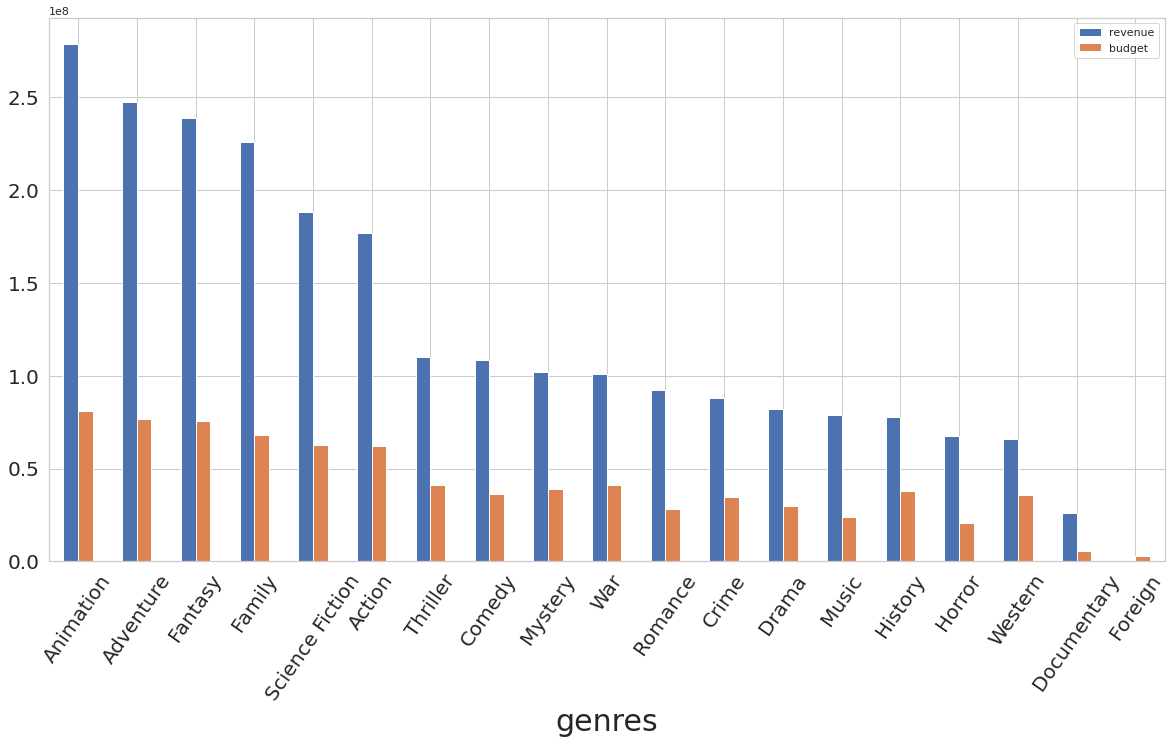

In [14]:
def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

def plotby_2bar(df,x,y):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    multi_groupby(df.dropna(subset=y),x,"name")[y].mean().sort_values(y,ascending=False).plot(kind="bar",ax=ax)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.show()


plotby_2bar(tmdb_5000,"genres",["revenue","budget"])

## Movies' release dates throughout decades

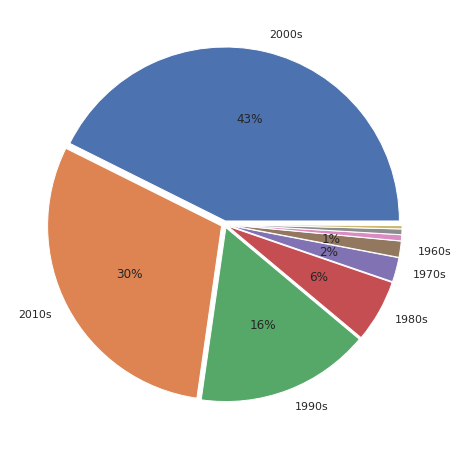

In [15]:
def count_pie(series):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    plt.show()

def count_decade_pie(df):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'))
    
count_decade_pie(tmdb_5000)

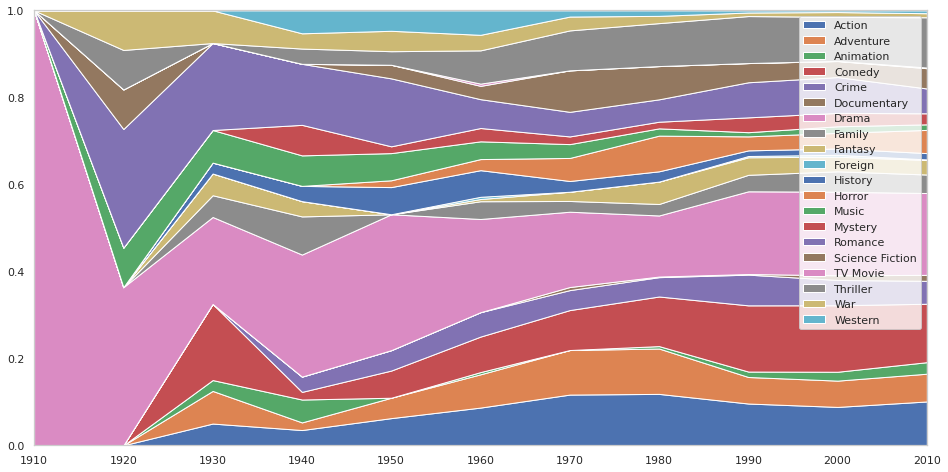

In [16]:
def multi_stackplot_10year(df,value):
    sns.set(style="whitegrid")
    df=df[["release_date",value]].dropna()
    df.release_date=df.release_date.apply(lambda x:int(x[:4])//10*10)
    df=df.sort_values("release_date")
    years=pd.Series(range(df["release_date"].min(),df["release_date"].max()+1,10),name="year")
    counts=[]
    groups=[]
    for (name,col) in multi_groupby(df,"genres","name"):
        groups.append(name)
        counts.append(pd.merge(years.to_frame(),col.groupby("release_date").size().rename("count").to_frame(),
                               how="left",left_on="year",right_on="release_date").fillna(0).astype(int)["count"])
    counts=np.array(counts)
    counts=counts.transpose(0,1)
    counts=counts/counts.sum(0)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.stackplot(years,counts,labels=groups)
    plt.xticks(years)
    plt.xlim(years.iloc[0],years.iloc[-1])
    plt.ylim(0,1)
    plt.legend()
    plt.show()

multi_stackplot_10year(tmdb_5000,"genres")

## Correlation between numeric features

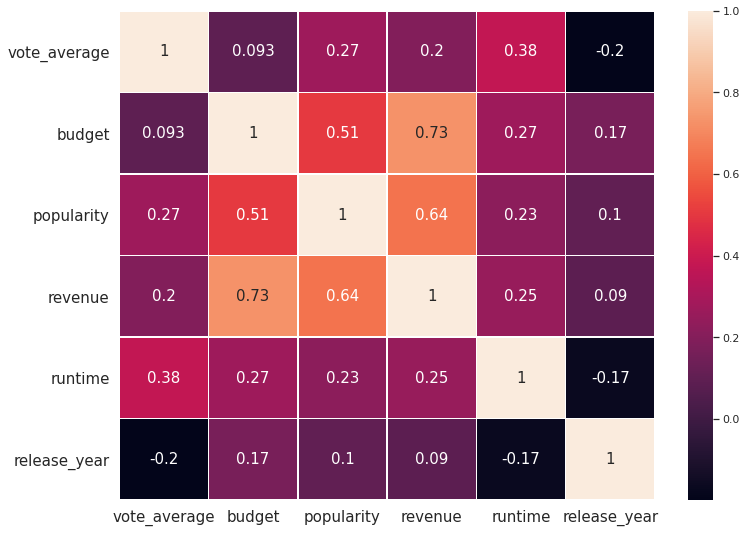

In [17]:
def plot_corr(df):
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    plt.show()

tmdb_5000["release_year"] = tmdb_5000.release_date.apply(lambda x: float(str(x)[0:4]))
plot_corr(tmdb_5000[["vote_average","budget","popularity","revenue","runtime","release_year"]])

## Data analysis
#### Clean the data

In [18]:
tmdb_5000 = tmdb_5000.replace(0, np.nan)
tmdb_5000 = tmdb_5000.dropna()

### 1. What area have the most influence to revenue?
### For numeric fields in data frame we calculate p-value from Pearson correlation to analyze the relationship between them

In [19]:
import scipy.stats  as stats

#### Polutations: <b>vote_average</b> and <b>revenue</b>
##### Test: two-tailed correlation p-test 
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>vote_average</b> and <b>revenue</b><br>
<b>H1</b>: There is statistically significant relationship between <b>vote_average</b> and <b>revenue</b>

In [20]:
r_va_r, p_va_r = stats.pearsonr(tmdb_5000['vote_average'], tmdb_5000['revenue'])

print("p-value: " + str(p_va_r))

p-value: 5.405550003042414e-19


We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>vote_average</b> and <b>revenue</b>

#### Polutations: <b>budget</b> and <b>revenue</b>
##### Test: two-tailed correlation p-test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>budget</b> and <b>revenue</b><br>
<b>H1</b>: There is statistically significant relationship between <b>budget</b> and <b>revenue</b>

In [21]:
r_va_r, p_va_r = stats.pearsonr(tmdb_5000['budget'], tmdb_5000['revenue'])

print("p-value: " + str(p_va_r))

p-value: 4.484471130358519e-205


We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>budget</b> and <b>revenue</b>

#### Polutations: <b>popularity</b> and <b>revenue</b>
##### Test: two-tailed correlation p-test 
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>popularity</b> and <b>revenue</b><br>
<b>H1</b>: There is statistically significant relationship between <b>popularity</b> and <b>revenue</b>

In [22]:
r_va_r, p_va_r = stats.pearsonr(tmdb_5000['popularity'], tmdb_5000['revenue'])

print("p-value: " + str(p_va_r))

p-value: 5.357142938838467e-106


We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>popularity</b> and <b>revenue</b>

#### Polutations: <b>runtime</b> and <b>revenue</b>
##### Test: two-tailed correlation p-test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>runtime</b> and <b>revenue</b><br>
<b>H1</b>: There is statistically significant relationship between <b>runtime</b> and <b>revenue</b>

In [23]:
r_va_r, p_va_r = stats.pearsonr(tmdb_5000['runtime'], tmdb_5000['revenue'])

print("p-value: " + str(p_va_r))

p-value: 2.1974682126023703e-39


We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>runtime</b> and <b>revenue</b>

#### Polutations: <b>release_year</b> and <b>revenue</b>
##### Test: two-tailed correlation p-test 
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>release_year</b> and <b>revenue</b><br>
<b>H1</b>: There is statistically significant relationship between <b>release_year</b> and <b>revenue</b>

In [24]:
r_va_r, p_va_r = stats.pearsonr(tmdb_5000['release_year'], tmdb_5000['revenue'])

print("p-value: " + str(p_va_r))

p-value: 0.1669035233472484


We have p-value > 0.025, so <b>accept the Null Hypothesis</b> => There is <b>no</b> statistically significant relationship between <b>release_year</b> and <b>revenue</b>

<b>First conclusion</b>: because <b>p-value</b> of the correlation between <b>budget</b> and <b>revenue</b> is smallest, 4.484471130358519e-205. So for numeric fields, <b>budget</b> field has most influence on <b>revenue</b>

### For categorical fields in data frame we calculate p-value from ANOVA test to analyze the relationship between them

#### Polutations: <b>revenue</b> from different <b>genres</b>
##### Test: two-tailed ANOVA test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>revenue</b> from different <b>genres</b><br>
<b>H1</b>: There is statistically significant relationship between <b>revenue</b> from different <b>genres</b>

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

data_genres = expand_multi_feature(tmdb_5000,"genres","name")

mod = ols("revenue~C(genres)", data = data_genres[["genres", "revenue"]]).fit()
anv = sm.stats.anova_lm(mod, type=2)
print(anv["PR(>F)"]["C(genres)"])

6.45330009823884e-92


We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>revenue</b> from different <b>genres</b>

#### Polutations: <b>revenue</b> from different <b>production_countries</b>
##### Test: two-tailed ANOVA test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>revenue</b> from different <b>production_countries</b><br>
<b>H1</b>: There is statistically significant relationship between <b>revenue</b> from different <b>production_countries</b>

In [26]:
data_production_countries = expand_multi_feature(tmdb_5000,"production_countries","name")

mod = ols("revenue ~ C(production_countries)", data = data_production_countries[["production_countries", "revenue"]]).fit()
anv = sm.stats.anova_lm(mod, type=2)
print(anv["PR(>F)"]["C(production_countries)"])

2.615904903285794e-05


We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>revenue</b> from different <b>production_countries</b>

#### Polutations: <b>revenue</b> from different <b>original_language</b>
##### Test: two-tailed ANOVA test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>revenue</b> from different <b>original_language</b><br>
<b>H1</b>: There is statistically significant relationship between <b>revenue</b> from different <b>original_language</b>

In [27]:
mod = ols("revenue ~ C(original_language)", data = data_genres[["original_language", "revenue"]]).fit()
anv = sm.stats.anova_lm(mod, type=2)
print(anv["PR(>F)"]["C(original_language)"])

0.0035068304391758167


We have p-value > 0.025, so <b>accept the Null Hypothesis</b> => There is <b>no</b> statistically significant relationship between <b>revenue</b> from different <b>original_language</b>

#### Polutations: <b>revenue</b> from different <b>keywords</b>
##### Test: two-tailed ANOVA test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>revenue</b> from different <b>keywords</b><br>
<b>H1</b>: There is statistically significant relationship between <b>revenue</b> from different <b>keywords</b>

We have p-value << 0.025, so <b>reject the Null Hypothesis</b> => There is statistically significant relationship between <b>revenue</b> from different <b>keywords</b>

#### Polutations: <b>revenue</b> from different <b>cast</b>
##### Test: two-tailed ANOVA test
##### Hypothesis:
<b>H0</b>: There is no statistically significant relationship between <b>revenue</b> from different <b>cast</b><br>
<b>H1</b>: There is statistically significant relationship between <b>revenue</b> from different <b>cast</b>

In [ ]:
data_cast = expand_multi_feature(tmdb_5000,"cast","name")

mod = ols("revenue ~ C(cast)", data = data_cast[["cast", "revenue"]]).fit()
anv = sm.stats.anova_lm(mod, type=2)
print(anv["PR(>F)"]["C(cast)"])

<b>Second conclusion</b>: because <b>p-value</b> of <b>revenue</b> from different <b>genres</b> is smallest, 6.45330009823884e-92. So for catagorical fields, <b>genres</b> field has most influence on <b>revenue</b>

### 2. How is a movie’s revenue and average score affected by its genre?

#### How genres affect movies' revenue

In [ ]:
data_genres_grouped = data_genres.groupby('genres')['revenue'].mean()
data_genres_grouped.sort_values(ascending=False).plot(kind = 'bar')

#### How genres affect movies' average score

In [ ]:
data_score_grouped = data_genres.groupby('genres')['vote_average'].mean()
data_score_grouped.sort_values(ascending=False).plot(kind = 'bar')

<b>Conclusion</b>: genres affect revenue (p-value: 6.45330009823884e-92) more than average score (p-value: 5.405550003042414e-19)

### 3. What influence does release date have on revenue?

In [ ]:
data_release_date = tmdb_5000[["release_date","revenue"]].copy()

# transfrom data
data_release_date.release_date = pd.to_datetime(data_release_date.release_date)
data_release_date['day']=data_release_date.release_date.dt.day
data_release_date['month']=data_release_date.release_date.dt.month
data_release_date['year']=data_release_date.release_date.dt.year

In [ ]:
revenue_day_grouped = data_release_date.groupby('day')['revenue'].mean()
revenue_day_grouped.sort_values(ascending=False).plot(y = ['revenue'],kind = 'bar')

In [ ]:
revenue_month_grouped = data_release_date.groupby('month')['revenue'].mean()
revenue_month_grouped.sort_values(ascending=False).plot(y = ['revenue'],kind = 'bar')

In [ ]:
revenue_year_grouped.plot(y = ['revenue'],kind = 'line')